In [40]:
#Pytorch Implementation of a 2 Layer MLP
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
from torchvision.datasets import MNIST
import matplotlib.pyplot as plt
import time

import numpy as np
import pandas as pd
import sklearn
from sklearn.metrics import confusion_matrix

In [21]:
class MLP(nn.Module):
  def __init__(self, input_size=784, num_classes=10, layers=[128, 64]):
    super(MLP, self).__init__()
    #Define the layers in your MLP
    self.d1 = nn.Linear(input_size, layers[0])  # input layer
    self.d2 = nn.Linear(layers[0], layers[1])   # hidden layer
    self.d3 = nn.Linear(layers[1], num_classes) # output layer

  def forward(self, x):
    #Define operations on input x using the layers that were defined
    x = F.relu(self.d1(x))
    x = F.relu(self.d2(x))
    x = F.log_softmax(self.d3(x), dim=1)
    return x

In [22]:
#Initalize your MLP
model = MLP()

#To use GPUs, set a device (cuda) and add it to your net
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

#define hyperparameters
learning_rate = 0.01
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [ ]:
!wget www.di.ens.fr/~lelarge/MNIST.tar.gz
!tar -zxvf MNIST.tar.gz

Transform = transforms.ToTensor()
train = MNIST(root='data/', train=True, download=True, transform=Transform)
train

In [10]:
test = MNIST(root='data/', train=False, download=True, transform=Transform)
test

Dataset MNIST
    Number of datapoints: 10000
    Root location: data/
    Split: Test
    StandardTransform
Transform: ToTensor()

In [11]:
image, label = train[0]
print('Shape:', image.shape, '\nlabel:', label)

Shape: torch.Size([1, 28, 28]) 
label: 5


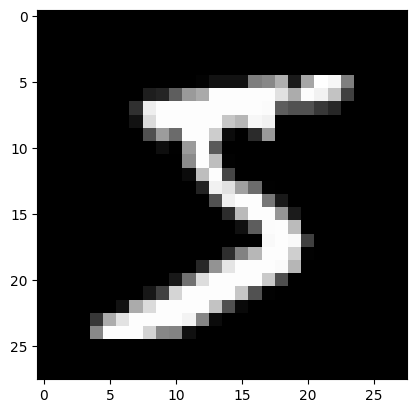

In [14]:
plt.imshow(image[0], cmap='gray')

In [16]:
train_loader = torch.utils.data.DataLoader(train, batch_size=100, shuffle=True)
test_loader = torch.utils.data.DataLoader(test, batch_size=500, shuffle=False)

In [25]:
for image, label in train_loader:
  print('Image:', image.shape, '\nLabel:', label.shape)
  break
print('Batch shape after flattening:', image.view(100, -1).size())

Image: torch.Size([100, 1, 28, 28]) 
Label: torch.Size([100])
Batch shape after flattening: torch.Size([100, 784])


In [26]:
#Training loop
epochs = 10
train_losses = []
train_correct = []
test_losses = []
test_correct = []
start_time = time.time()

for t in range(epochs):
    train_corr = 0
    test_corr = 0
    for b, (x_train, y_train) in enumerate(train_loader):
        b+=1
        y_pred = model(x_train.view(100, -1))
        loss = criterion(y_pred, y_train)

        predicted = torch.max(y_pred.data, 1)[1]
        batch_corr = (predicted == y_train).sum()
        train_corr += batch_corr

        optimizer.zero_grad() #reset the gradients from previous batch
        loss.backward() #backpropagation
        optimizer.step() #update the model's parameters based on the gradients

        if b%200 == 0:
            print(f'Epoch {t} Loss: {loss.item()} Accuracy: {train_corr.item()*100/(100*b)}%')
    
    train_losses.append(loss)
    train_correct.append(train_corr)

    with torch.no_grad(): # forward pass without computing gradients
        for b, (x_test, y_test) in enumerate(test_loader):
            y_val = model(x_test.view(500, -1))
            predicted = torch.max(y_val.data, 1)[1]
            test_corr += (predicted == y_test).sum()
    
    loss = criterion(y_val, y_test)
    test_losses.append(loss)
    test_correct.append(test_corr)

print(f'\nDuration: {time.time() - start_time:.0f} seconds')

Epoch 0 Loss: 2.246330976486206 Accuracy: 23.29%
Epoch 0 Loss: 2.0985686779022217 Accuracy: 37.825%
Epoch 0 Loss: 1.6619656085968018 Accuracy: 45.395%
Epoch 1 Loss: 1.1530166864395142 Accuracy: 70.46%
Epoch 1 Loss: 0.7501543164253235 Accuracy: 74.305%
Epoch 1 Loss: 0.5224775075912476 Accuracy: 76.51833333333333%
Epoch 2 Loss: 0.5544029474258423 Accuracy: 83.555%
Epoch 2 Loss: 0.539821445941925 Accuracy: 84.285%
Epoch 2 Loss: 0.3481768071651459 Accuracy: 85.02833333333334%
Epoch 3 Loss: 0.572827935218811 Accuracy: 87.235%
Epoch 3 Loss: 0.38236525654792786 Accuracy: 87.755%
Epoch 3 Loss: 0.31393343210220337 Accuracy: 87.94333333333333%
Epoch 4 Loss: 0.6142944097518921 Accuracy: 89.035%
Epoch 4 Loss: 0.3373410105705261 Accuracy: 88.965%
Epoch 4 Loss: 0.3333203196525574 Accuracy: 89.28833333333333%
Epoch 5 Loss: 0.21901702880859375 Accuracy: 89.765%
Epoch 5 Loss: 0.42148154973983765 Accuracy: 89.965%
Epoch 5 Loss: 0.3152449131011963 Accuracy: 90.025%
Epoch 6 Loss: 0.3564693331718445 Accura

In [36]:
# Test accuracy for last epoch
print(f'Test accuracy: {test_correct[-1].item()*100/10000:.3f}%')

Test accuracy: 92.040%


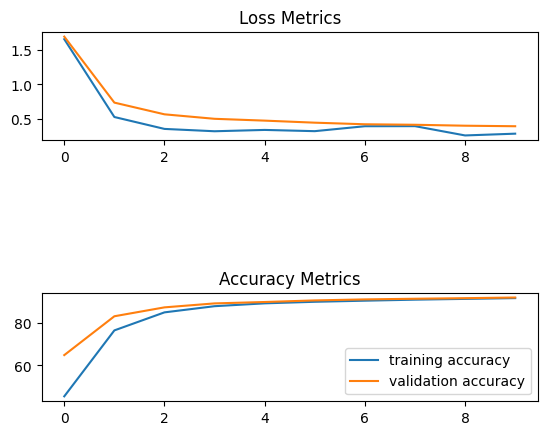

In [42]:
plt.subplot(3, 1, 1)
plt.plot([loss.detach().numpy() for loss in train_losses], label='training loss')
plt.plot([loss.detach().numpy() for loss in test_losses], label='validation loss')
plt.title('Loss Metrics')

plt.subplot(3, 1, 3)
plt.plot([t/600 for t in train_correct], label='training accuracy')
plt.plot([t/100 for t in test_correct], label='validation accuracy')
plt.title('Accuracy Metrics')

plt.legend()